In [1]:
import random as rd
import numpy as np
from math import *
from matplotlib import pyplot as plt
from matplotlib import cm
from numpy import linalg as LA
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D

In [73]:
#generation of the input and expected output
Xliste=[[rd.randint(-5,5),rd.randint(-5,5)]for k in range(50)]
X=Xliste/np.amax(Xliste,axis=0)

#function we want to esimate
def mafun (x0,x1):
    return sin(np.sqrt(x0**2+x1**2))

#exact expected output
Yliste=[[mafun(k[0],k[1])] for k in X]
Y=Yliste/np.amax(Yliste,axis=0)
print(X,Y)

[[ 0.2  0.2]
 [-1.  -0.2]
 [-0.4  0.2]
 [-0.8 -0.8]
 [ 0.2 -1. ]
 [ 0.4 -0.6]
 [-0.4 -0.8]
 [ 0.6 -0.2]
 [-1.  -0.8]
 [ 0.8  1. ]
 [ 0.  -1. ]
 [-1.   1. ]
 [ 0.8 -0.4]
 [ 0.4  1. ]
 [-0.4  0.4]
 [ 0.4  0. ]
 [ 0.6  0.8]
 [ 0.   0.6]
 [-0.4 -1. ]
 [ 0.4 -0.8]
 [ 1.  -0.2]
 [ 0.8 -1. ]
 [-0.6 -0.2]
 [-1.  -0.2]
 [ 1.  -0.4]
 [ 0.4 -0.8]
 [ 1.  -0.2]
 [ 0.6 -0.8]
 [-0.2 -1. ]
 [-0.2 -0.2]
 [ 0.  -0.6]
 [ 0.8  0.8]
 [-0.2 -0.6]
 [ 0.8  0.8]
 [ 0.   0. ]
 [-0.6  0.4]
 [ 0.   0.2]
 [-0.8  0. ]
 [ 0.6  0. ]
 [-1.   0.4]
 [ 1.  -0.8]
 [-0.4 -0.4]
 [-1.  -1. ]
 [-0.2 -0.6]
 [ 0.8  0.2]
 [ 0.8 -0.4]
 [-0.6  0.4]
 [ 1.   0. ]
 [-0.6  0. ]
 [ 0.6  0. ]] [[0.28254318]
 [0.86255796]
 [0.43781104]
 [0.91620513]
 [0.86255796]
 [0.66839616]
 [0.78950955]
 [0.59844857]
 [0.97006263]
 [0.97006263]
 [0.85189309]
 [1.        ]
 [0.78950955]
 [0.89146167]
 [0.5426332 ]
 [0.39424151]
 [0.85189309]
 [0.5716359 ]
 [0.89146167]
 [0.78950955]
 [0.86255796]
 [0.97006263]
 [0.59844857]
 [0.86255796]
 [0.89146167]

In [75]:
#neural network definition

class Neural_Net (object):
    def __init__(self):
        #define hyperparameters
        self.inputLayerSize= 2
        self.outputLayerSize = 1
        self.hiddenLayerSize =20
        #define weight matrices
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)

        #define the activation function
    def sigmoid(self,z):
        return 1/(1+np.exp(-z))
    def sigmoidprime(self,z):
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def forward(self,X):
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yChapeau= self.sigmoid(self.z3)
        return yChapeau

    #meilleure par definition du tuto
    def costfun(self, x,y):
        self.yHat= self.forward(X)
        J=0.5*sum((y-self.yHat)**2)
        return J
    
    def costfunprime(self, x, y):
        self.yChapeau = self.forward(x)

        delta3 = np.multiply(-(y-self.yChapeau),self.sigmoidprime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)

        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidprime(self.z2)
        dJdW1 = np.dot(x.T,delta2)

        return dJdW1, dJdW2
        
    def computeGradients(self, X, Y):
        dJdW1, dJdW2 = self.costfunprime(X, Y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))


In [76]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costfun(self.X, self.Y))   
        
    def costFunctionWrapper(self, params, X, Y):
        self.N.setParams(params)
        cost = self.N.costfun(X, Y)
        grad = self.N.computeGradients(X,Y)
        
        return cost, grad
        
    def train(self, X, Y):
        #Make an internal variable for the callback function:
        self.X = X
        self.Y = Y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, Y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [91]:
def computeNumericalGradient(N, X, Y):
    paramsInitial = N.getParams()
    numgrad = np.zeros(paramsInitial.shape)
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4

    for p in range(len(paramsInitial)):
         #Set perturbation vector
        perturb[p] = e
        N.setParams(paramsInitial + perturb)
        loss2 = N.costfun(X, Y)
            
        N.setParams(paramsInitial - perturb)
        loss1 = N.costfun(X, Y)

            #Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
        perturb[p] = 0
            
        #Return Params to original value:
    N.setParams(paramsInitial)

    return numgrad

In [92]:
NN = Neural_Net()

In [93]:
#evaluating our gradient : must be at least 10-9
numgrad = computeNumericalGradient(NN, X, Y)
grad = NN.computeGradients(X,Y)

In [94]:
print(LA.norm(grad-numgrad)/LA.norm(grad+numgrad))


1.6277773717592023e-10


In [95]:
#training nn
T=trainer(NN)
T.train(X,Y)

         Current function value: 0.885779
         Iterations: 200
         Function evaluations: 208
         Gradient evaluations: 208


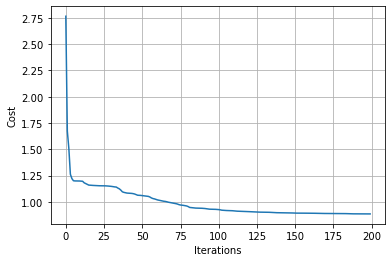

In [96]:
#plotting optimization progression
plt.plot(T.J)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

NN estimation plotting

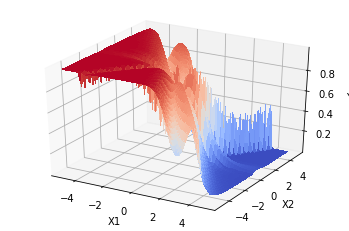

In [97]:
#plotting 3d
fig = plt.figure()
ax = fig.gca(projection='3d')
#creating input array
x0= np.linspace(-5, 5, 100)
x1= np.linspace(-5, 5, 100)

a, b  = np.meshgrid(x0, x1)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

#compuing the estimated results with our nn
allOutputs = NN.forward(allInputs)

surfright = ax.plot_surface(a, b, allOutputs.reshape(100,100),cmap=cm.coolwarm,
                     linewidth=0, antialiased=False)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()


real expectation

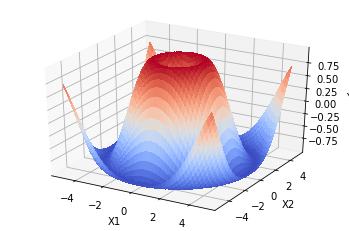

In [98]:
#plotting 3d
fig = plt.figure()
ax = fig.gca(projection='3d')
#creating input array
x0= np.linspace(-5, 5, 100)
x1= np.linspace(-5, 5, 100)

a, b  = np.meshgrid(x0, x1)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

#creating array of the real expected result
R = np.sqrt(a**2 + b**2)
rightOutputs = np.sin(R)
surfright = ax.plot_surface(a, b, rightOutputs.reshape(100,100),cmap=cm.coolwarm,
                     linewidth=0, antialiased=False)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()
